In [1]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from pyscf import gto, scf, dft
import pyvista as pv
from sklearn.decomposition import PCA

pv.set_jupyter_backend("trame")

# Visualization of MOs and AOs

## Atomic orbitals of HF

Real spherical harmonics: https://en.wikipedia.org/wiki/Table_of_spherical_harmonics#Real_spherical_harmonics

Basis set exchange: https://www.basissetexchange.org/

In [2]:
mol = gto.M(atom="F 0 0 0; H 0.917 0 0", basis="6-31G(d,p)", unit="bohr")

M = 100
x = np.linspace(-3, 4, M)
y = np.linspace(-3.5, 3.5, M)
z = np.linspace(-3.5, 3.5, M)
x, y, z = np.meshgrid(x, y, z)
coords = np.stack([x, y, z], axis=-1).reshape(-1, 3)
aos = mol.eval_gto("GTOval", coords).reshape(M, M, M, -1)

In [3]:
def plot_2d(values: np.ndarray, labels: list[str], clip: float = 0.1):
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    max_abs = np.max(np.abs(values)) * clip
    
    for i, ax in enumerate(axes.flat[:-1]):
        img = ax.imshow(values[:, :, M//2, i], vmin=-max_abs, vmax=max_abs, cmap="RdBu", extent=(-3, 4, -3.5, 3.5))
        ax.scatter(mol.atom_coords()[0, 0], mol.atom_coords()[0, 1], c="green", s=20, marker=".", alpha=0.5)
        ax.scatter(mol.atom_coords()[1, 0], mol.atom_coords()[1, 1], c="black", s=10, marker=".", alpha=0.5)
        ax.set_title(labels[i])
        ax.set_axis_off()
        ax.aspect = 1
    
    fig.colorbar(img, ax=axes[3,4], orientation="vertical", location="left", fraction=0.1, extend="both")
    axes[3,4].set_axis_off()
    
    plt.tight_layout()
    plt.show()

In [4]:
def plot_3d(values: np.ndarray, labels: list[str]):
    grid = pv.StructuredGrid(x, y, z)   
    pv.set_plot_theme('document')
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    
    for i, ax in enumerate(axes.flat[:-1]):
        grid["vol"] = values[:,:,:,i].flatten()
        contours = grid.contour([-0.1, 0.1])
            
        p = pv.Plotter()
        p.add_mesh(contours, scalars=contours.points[:, 2], show_scalar_bar=False)
        img = p.screenshot()
        
        ax.imshow(img)
        ax.set_title(labels[i])
        ax.set_axis_off()
        
    axes[3,4].set_axis_off()
    plt.show()

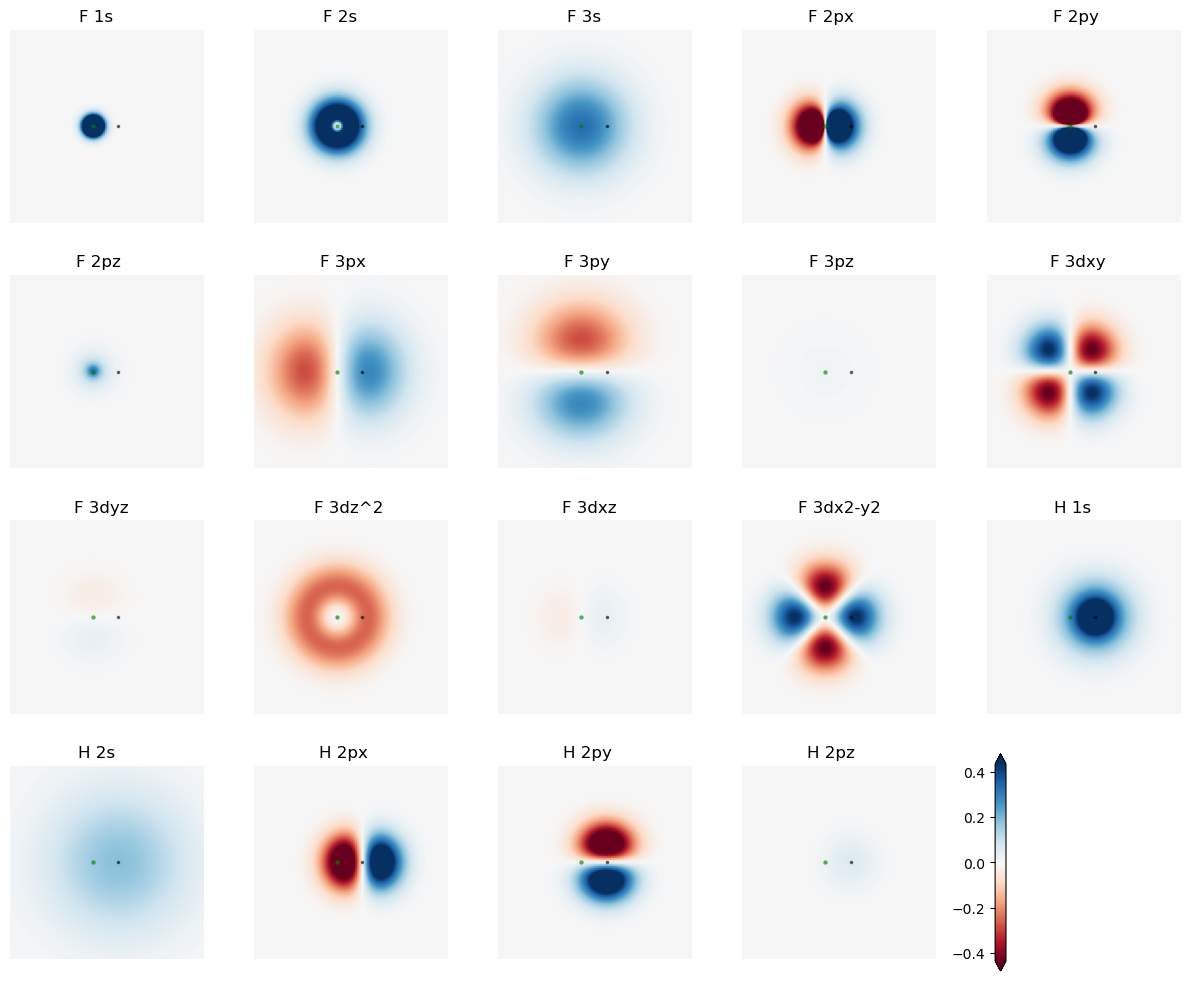

In [5]:
plot_2d(aos, [label[2:] for label in mol.ao_labels()], clip=0.05)

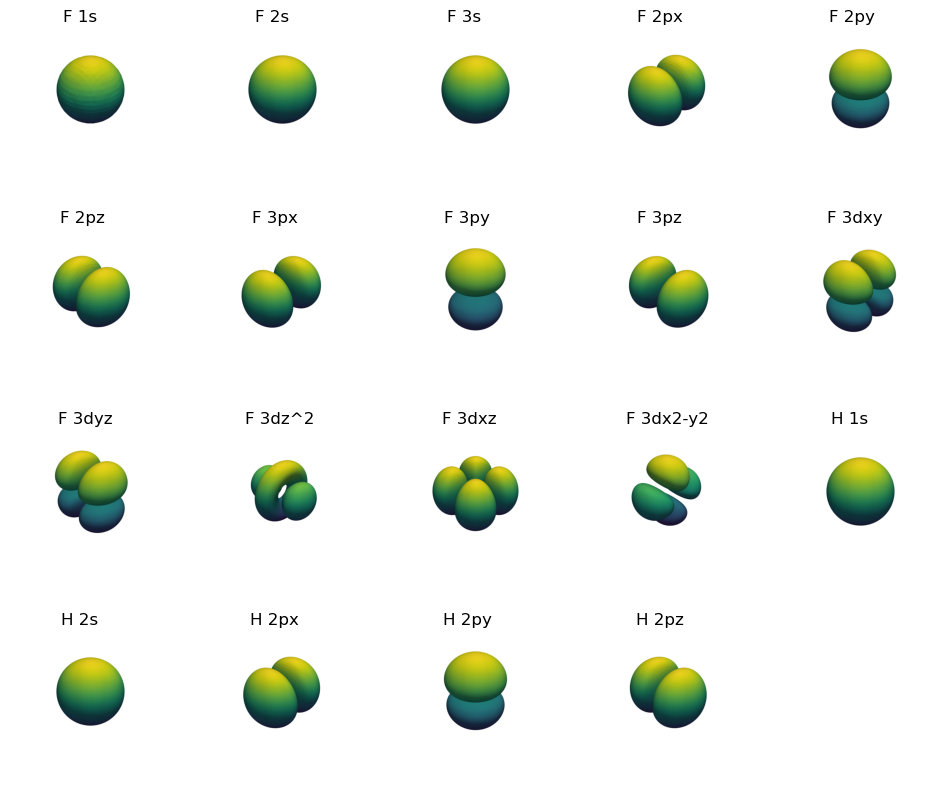

In [6]:
plot_3d(aos, [label[2:] for label in mol.ao_labels()])

## Molecular orbitals of HF

In [7]:
mf = scf.RHF(mol)
mf.init_guess = "hueckel"
mf.run()

coeffs = mf.mo_coeff
mo = np.einsum("xyzi,ij->xyzj", aos, coeffs)
print("MO occupation:", mf.mo_occ)

converged SCF energy = -99.2096017583305
MO occupation: [2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


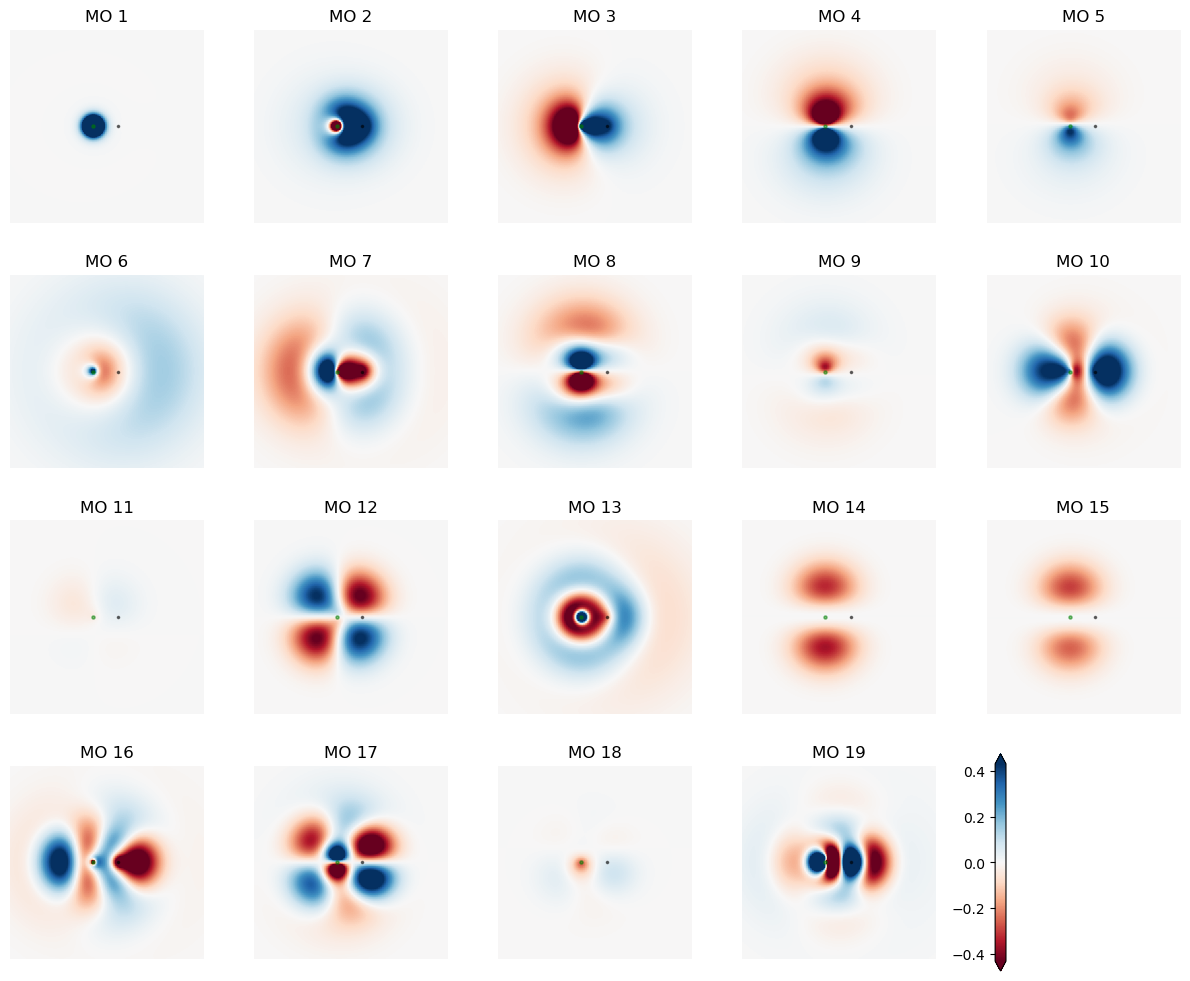

In [8]:
plot_2d(mo, [f"MO {i+1}" for i in range(mo.shape[-1])], clip=0.05)

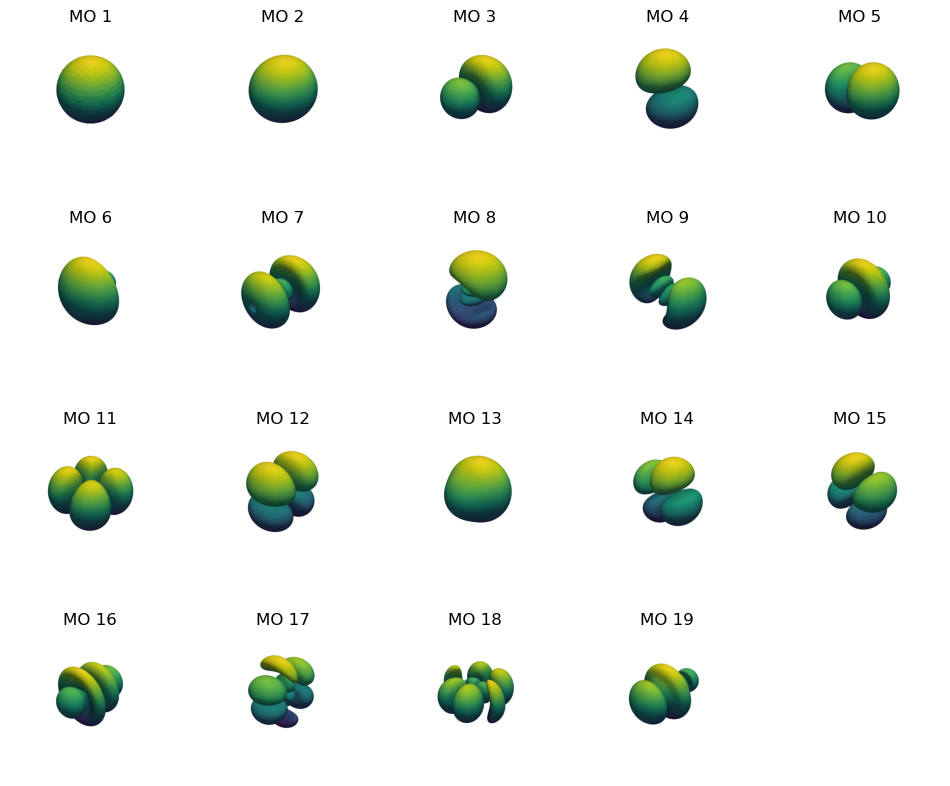

In [9]:
plot_3d(mo, [f"MO {i+1}" for i in range(mo.shape[-1])])

## Electron density

In accordance with exercise 2.2(c), the electron density is given by
\begin{align}
    \rho(\vec r) &= \sum_i^N |\phi_i(\vec r)|^2 \\
    &= \sum_i^N \sum_\mu \omega_\mu(\vec r) C_{\mu i} \sum_\nu \omega_\nu(\vec r) C_{\nu i} \\
    &= \sum_{\mu\nu} \omega_\mu(\vec r) D_{\mu\nu} \omega_\nu(\vec r),
\end{align}
where $D_{\mu\nu} = \sum_i^N C_{\mu i} C_{\nu i}$ is the density matrix and $\omega_\nu(\vec r)$ are the atomic orbitals.

In [10]:
# check if the density is correctly normalized
grid = dft.grid.Grids(mol)
grid.level = 4
grid.build()
ao_grid = mol.eval_gto("GTOval", grid.coords)

den = np.einsum("pi,ij,pj->p", ao_grid, mf.make_rdm1(), ao_grid)
print("number of electrons:", mol.nelectron)
print("integrated density: ", np.sum(den * grid.weights))

number of electrons: 10
integrated density:  10.000000041155896


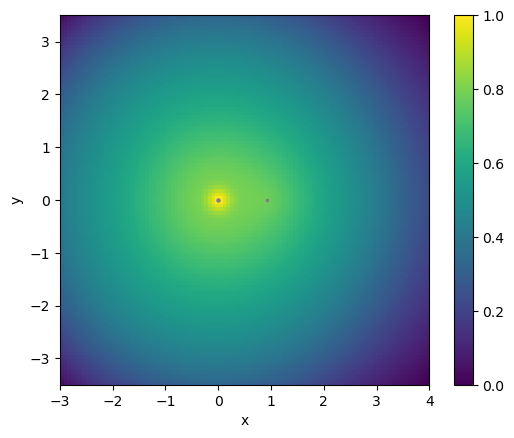

In [11]:
dm_init = mf.get_init_guess()
dm_final = mf.make_rdm1()

density = np.einsum("xyzi,ij,xyzj->xyz", aos, dm_final, aos)

plt.imshow(np.log(density[:,:,M//2]), cmap="viridis", extent=(-3, 4, -3.5, 3.5))
plt.scatter(mol.atom_coords()[0, 0], mol.atom_coords()[0, 1], c="gray", s=20, marker=".")
plt.scatter(mol.atom_coords()[1, 0], mol.atom_coords()[1, 1], c="gray", s=10, marker=".")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

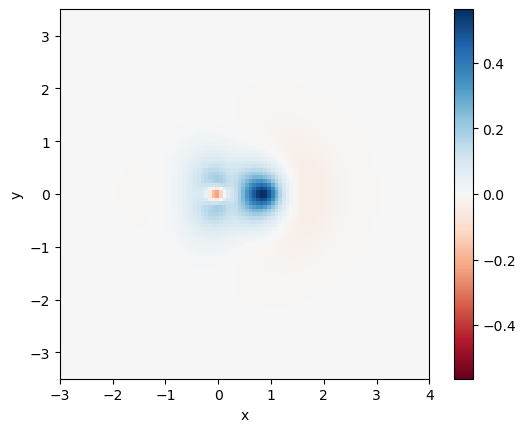

In [12]:
density_diff = np.einsum("...i,ij,...j->...", aos, dm_final - dm_init, aos)
vmax = np.max(np.abs(density_diff))

plt.imshow(density_diff[:,:,M//2], cmap="RdBu", extent=(-3, 4, -3.5, 3.5), vmin=-vmax, vmax=vmax)
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# PCA on Fock matrix

The Fock matrix is symmetric, so we can store only the upper half.

In [13]:
def store_fock_matrices(scf_method):
    """Helper function to store the upper half of the Fock matrix."""
    fock_matrices = []

    def get_fock_callback(envs):
        fock = envs['fock']
        fock_matrices.append(fock[np.triu_indices(fock.shape[0])])

    scf_method.callback = get_fock_callback
    scf_method.run()
    return fock_matrices

In [14]:
def run_scf_and_collect(mol, init_guess, method, damping=0.2):
    """Run SCF calculations with different settings and store Fock matrices."""
    mf = scf.RHF(mol)
    mf.verbose = 0
    mf.init_guess = init_guess

    if method == 'no DIIS, no damping':
        mf.diis = False
        # mf.diis_damp = 0.0
    elif method == 'DIIS, no damping':
        mf.diis = True
        mf.diis_damp = 0.0
    elif method == 'no DIIS, damping':
        mf.diis_start_cycle = 1e3
        mf.damp = damping
    elif method == 'DIIS, damping':
        mf.diis = True
        mf.diis_damp = damping
    else:
        raise ValueError(f'Unknown method: {method}')

    fock_matrices = store_fock_matrices(mf)
    label = f'{init_guess} init, {method}'
    print(f'{label}: {len(fock_matrices)} iterations')
    return fock_matrices, label

In [15]:
def perform_pca_and_plot(all_fock_matrices):
    pca = PCA(n_components=2)
    fock_np = np.vstack(list(all_fock_matrices.values()))
    pca.fit(fock_np)

    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap('tab10')  # Use a colormap with sufficient distinct colors
    color_idx = 0

    for label, fock_matrices in all_fock_matrices.items():
        transformed_subset = pca.transform(fock_matrices)
        color = cmap(color_idx)
        color_idx += 1

        plt.plot(transformed_subset[:, 0], transformed_subset[:, 1], '-', label=label, color=color)
        for i, (x, y) in enumerate(transformed_subset):
            plt.text(x, y, str(i + 1), fontsize=9, color=color)

    plt.legend()
    plt.title('PCA of Fock Matrices for Different SCF Methods')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    # plt.gca().set_aspect(1)
    plt.show()

minao init, no DIIS, no damping: 20 iterations
minao init, no DIIS, damping: 13 iterations
minao init, DIIS, no damping: 8 iterations
minao init, DIIS, damping: 8 iterations


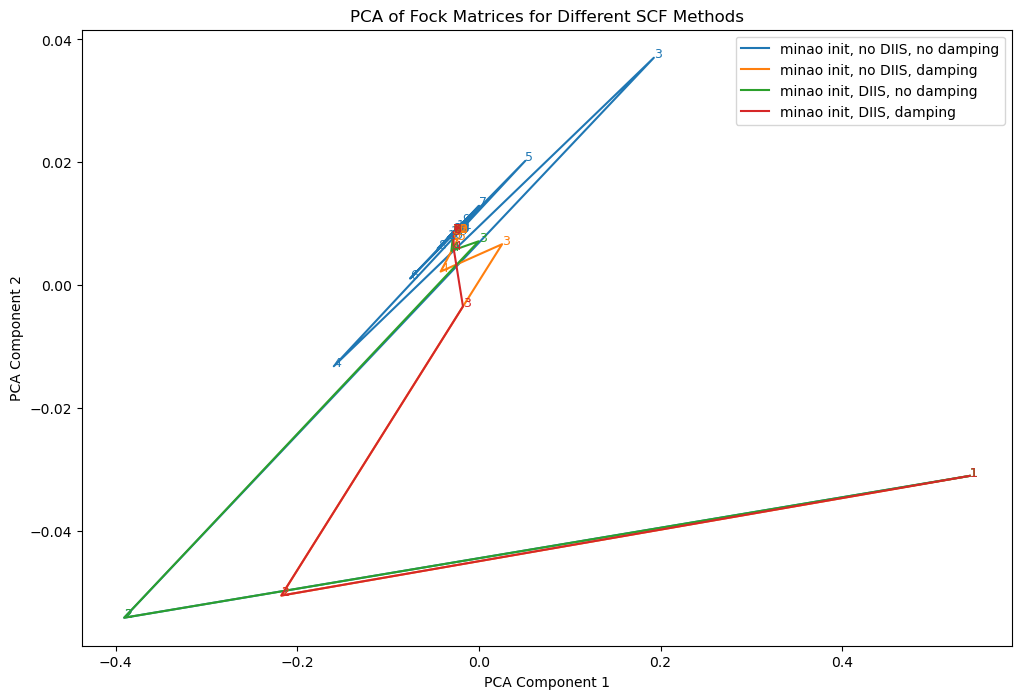

In [16]:
# Define the HF molecule
water_str = "O -0.0087 0.3953 -0.0000; \
              H 0.7976 -0.1944 0.0000; \
              H -0.7888 -0.2009 -0.0000;"
mol_water = gto.M(
    atom=water_str,
    basis='6-31G(2df,p)',
)

# Collect data for different initial guesses and methods
all_fock_matrices = dict()
initial_guesses = ['minao']  # , 'atom']
methods = ['no DIIS, no damping', 'no DIIS, damping', 'DIIS, no damping', 'DIIS, damping']
for init_guess, method in product(initial_guesses, methods):
    fock_matrices, label = run_scf_and_collect(mol_water, init_guess, method)
    all_fock_matrices[label] = fock_matrices

# Perform PCA and plot all results
perform_pca_and_plot(all_fock_matrices)